Using TensorFlow backend.


(50000, 28, 28) (50000,)


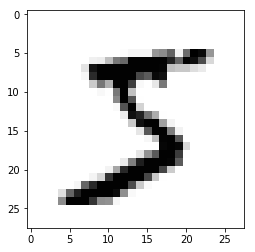

In [1]:
from preprocessed_mnist import load_dataset
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()
print(X_train.shape, y_train.shape)
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(X_train[0], cmap="Greys");

## Preparation

Relaunch tensorboard, and import useful libraries.

In [2]:
! killall tensorboard
import os
os.system("tensorboard --logdir=/tmp/tboard --port=7007 &");

import tensorflow as tf

import numpy as np

No matching processes belonging to you were found


# Data inspection and preparation

We first take a look at the data, and prepare a version having just two classes.

In [ ]:
X_train.shape

In [3]:
y_train[:10]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4], dtype=uint8)

Let's create a flattened version of the data, because tensorflow has difficulty computing gradients across a reshape node.

In [ ]:
with tf.variable_scope("1nn-reshaper"):
    # input shape
    x = tf.placeholder(tf.float32, shape=(None, rows, cols), name="input_X")
    y = tf.placeholder(tf.uint8, shape=(None,), name="input_Y")

    one_hot_y = tf.one_hot(y, 10)
    flat_x = tf.reshape(x, [-1, rows * cols])

X_train_flat, y_train_one_hot = s.run([flat_x, one_hot_y], feed_dict={
    x: X_train,
    y: y_train
})

## Single layer neural network

We first create a simple single layer neural network. We use a one_hot encode layer and a reshape layer to create a flat X. This will prove to be troublesome in the future, but it works for the first version. We use a softmax function to compute the predicted classes.

Also, for debugging, we create the `correct_prediction` and `accuracy` nodes, to avoid having to compute these metrics by hand after running the network.

In [4]:
rows = 28
cols = 28
classes = 10

tf.reset_default_graph()
s = tf.InteractiveSession()

with tf.variable_scope("1nn"):
    weights = tf.get_variable("weights", 
                              [rows * cols, classes],
                              initializer=tf.random_normal_initializer(mean=0, stddev=1e-3),
                              dtype=tf.float32)
    b = tf.get_variable("bias", [classes],
                    initializer=tf.random_uniform_initializer(minval=0, maxval=1e-3),
                    dtype=tf.float32)

    input_X = tf.placeholder(tf.float32, shape=(None, rows, cols), name="input_X")
    input_y = tf.placeholder(tf.uint8, shape=(None,), name="input_Y")

    one_hot_y = tf.one_hot(input_y, classes)
    flat_X = tf.reshape(input_X, [-1, rows * cols])
    
    predicted_y = tf.nn.softmax(tf.matmul(flat_X, weights) + b)
    class_loss = -tf.log(predicted_y) * one_hot_y - tf.log(1 - predicted_y) * (1 - one_hot_y)
    loss = tf.reduce_mean(class_loss)
    
    correct_prediction = tf.equal(tf.cast(input_y, tf.int64), tf.argmax(predicted_y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

Let's test that the weights get correctly initialized.

In [5]:
s.run(tf.global_variables_initializer())
print(s.run([weights, b]))

[array([[  5.79033105e-04,   5.30614925e-04,   3.36251920e-04, ...,
          2.76694028e-03,   1.15641451e-03,  -1.63831748e-03],
       [ -1.58736168e-03,   1.21381214e-04,  -2.19016010e-03, ...,
          1.32015243e-03,   4.94840438e-04,   1.25256577e-03],
       [ -3.99170749e-05,   3.11565556e-04,   6.22138497e-04, ...,
         -6.53253344e-04,   4.62306161e-05,  -8.24748189e-04],
       ..., 
       [  1.43660349e-04,  -8.87794231e-05,   2.98190513e-04, ...,
          2.59238703e-04,   4.58338851e-04,  -1.08343644e-04],
       [  8.14772618e-04,   6.56542543e-04,   1.24888425e-03, ...,
         -9.27994843e-04,  -7.12979992e-04,   1.58063893e-03],
       [  5.21749025e-04,  -1.53792300e-03,   1.33906677e-03, ...,
         -1.45935116e-03,  -2.51419330e-03,   1.67449866e-03]], dtype=float32), array([  2.86260271e-04,   9.36999510e-04,   8.29001729e-05,
         5.16016968e-04,   8.68820585e-04,   6.75416377e-04,
         8.76370585e-04,   2.40242618e-04,   2.61650217e-04,
      

Let's test that the network computes different values correctly, or at least that they seem to be roughly correct. I struggled a bit with different data shapes and wrong initialization. I decided to keep this step to show what pains I went through.

In [7]:
s.run([weights, b, predicted_y, class_loss, one_hot_y, loss, correct_prediction, accuracy],
     {
         input_X: X_train[:3],
         input_y: y_train[:3]
     })

[array([[  5.79033105e-04,   5.30614925e-04,   3.36251920e-04, ...,
           2.76694028e-03,   1.15641451e-03,  -1.63831748e-03],
        [ -1.58736168e-03,   1.21381214e-04,  -2.19016010e-03, ...,
           1.32015243e-03,   4.94840438e-04,   1.25256577e-03],
        [ -3.99170749e-05,   3.11565556e-04,   6.22138497e-04, ...,
          -6.53253344e-04,   4.62306161e-05,  -8.24748189e-04],
        ..., 
        [  1.43660349e-04,  -8.87794231e-05,   2.98190513e-04, ...,
           2.59238703e-04,   4.58338851e-04,  -1.08343644e-04],
        [  8.14772618e-04,   6.56542543e-04,   1.24888425e-03, ...,
          -9.27994843e-04,  -7.12979992e-04,   1.58063893e-03],
        [  5.21749025e-04,  -1.53792300e-03,   1.33906677e-03, ...,
          -1.45935116e-03,  -2.51419330e-03,   1.67449866e-03]], dtype=float32),
 array([  2.86260271e-04,   9.36999510e-04,   8.29001729e-05,
          5.16016968e-04,   8.68820585e-04,   6.75416377e-04,
          8.76370585e-04,   2.40242618e-04,   2.61650

Finally, compute accuracy metrics when training the network.

In [8]:
s.run(tf.global_variables_initializer())

losses = []
test_accuracies = []
train_accuracies = []

for i in range(30):
    s.run(optimizer, {input_X: X_train, input_y: y_train})
    loss_i = s.run(loss,  {input_X: X_train, input_y: y_train})
    losses += [loss_i]
    train_accuracies += [s.run(accuracy, {input_X:X_train, input_y: y_train})]
    test_accuracies += [s.run(accuracy, {input_X:X_test, input_y: y_test})]


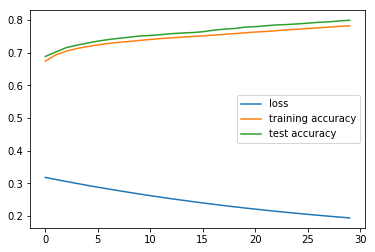

In [9]:
plt.figure()
plt.plot(losses);
plt.plot(train_accuracies)
plt.plot(test_accuracies);
plt.legend(['loss', 'training accuracy', 'test accuracy'])


## Multilayer neural network

In this neural network, we use a second 50 neuron layer. The first layer has a sigmoid activation function.

In [28]:
from preprocessed_mnist import load_dataset
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()
print(X_train.shape, y_train.shape)

import tensorflow as tf

rows = 28
cols = 28
classes = 10

hidden_size = 50

tf.reset_default_graph()
s = tf.InteractiveSession()

with tf.variable_scope("1nn-2layers"):
    # input shape
    input_x = tf.placeholder(tf.float32, shape=(None, rows, cols), name="input_X")
    label_y = tf.placeholder(tf.uint8, shape=(None,), name="input_Y")

    y_ = tf.one_hot(label_y, classes, dtype=tf.float32)
    x = tf.reshape(input_x, [-1, rows * cols])
    
    sigma = np.sqrt(2. / 10.)
    sigma = 1.
    print("sigma", sigma)
  
    # input layer
    W1 = tf.get_variable("weights", 
                              [rows * cols, hidden_size],
                              initializer=tf.random_normal_initializer(mean=0, stddev=sigma),
                              dtype=tf.float32)
    b1 = tf.get_variable("bias", [hidden_size],
                    initializer=tf.random_normal_initializer(mean=0, stddev=sigma),
                    dtype=tf.float32)

    y1 = tf.nn.sigmoid(tf.matmul(x, W1) + b1)

    # hidden layer
    W2 = tf.get_variable("hidden_weights", 
                              [hidden_size, classes],
                              initializer=tf.random_normal_initializer(mean=0, stddev=sigma),
                              dtype=tf.float32)
    b2 = tf.get_variable("hidden_bias", [classes],
                    initializer=tf.random_normal_initializer(mean=0, stddev=sigma),
                    dtype=tf.float32)

    y2 = tf.nn.softmax(tf.matmul(y1, W2) + b2)

    class_loss = -tf.log(y2) * y_ - tf.log(1 - y2) * (1 - y_)
    loss = tf.reduce_mean(class_loss)

    # output
    y = y2

    loss = tf.reduce_mean(-tf.reduce_sum(tf.cast(y_, tf.float32) * tf.log(y), 
    reduction_indices=[1]))
    
    correct_prediction = tf.equal(tf.argmax(y_, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    optimizer = tf.train.GradientDescentOptimizer(0.1).minimize(loss)
    
    s.run(tf.global_variables_initializer())



(50000, 28, 28) (50000,)
sigma 1.0


Next, we create a generator that will provide us with randomized minibatches, to do incremental training.

In [29]:
import random

class MiniBatchGenerator:
    def __init__(self, X, y, batch_size):
        self.X = X.copy()
        self.y = y.copy()
        self.batch_size = batch_size
        self.current_i = 0
        self.total_size = len(self.X)
        
        self.reshuffle()
        
    def reshuffle(self):        
        idxs = list(range(self.total_size))
        random.shuffle(idxs)
        self.X_shuffled = self.X[idxs]
        self.y_shuffled = self.y[idxs]        
        
    def __iter__(self):
        return self
    
    def __next__(self):
        return self.next()
    
    def next(self):
        res_X = []
        res_y = []
        
        end_i = self.current_i + self.batch_size
        
        if end_i > self.total_size:
            rem = end_i - self.total_size
            res_X = self.X_shuffled[self.current_i:]
            res_y = self.y_shuffled[self.current_i:]
            self.reshuffle()
            res_X = np.append(res_X, self.X_shuffled[:rem], axis=0)
            res_y = np.append(res_y, self.y_shuffled[:rem])
            self.current_i = rem
        else:
            res_X = self.X_shuffled[self.current_i:end_i]
            res_y = self.y_shuffled[self.current_i:end_i]
            self.current_i = end_i
        
        return res_X, res_y

In [30]:
batch_gen = MiniBatchGenerator(np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10]),
                               np.array(list("abcdefghij")),
                               batch_size = 3);

print(batch_gen.next())
print(batch_gen.next())
print(batch_gen.next())
print(batch_gen.next())
print(batch_gen.next())

batch_gen = MiniBatchGenerator(np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10]),
                               np.array(list("abcdefghij")),
                               batch_size = 5);

print(batch_gen.next())
print(batch_gen.next())
print(batch_gen.next())
print(batch_gen.next())
print(batch_gen.next())

(array([ 5,  2, 10]), array(['e', 'b', 'j'],
      dtype='<U1'))
(array([9, 3, 4]), array(['i', 'c', 'd'],
      dtype='<U1'))
(array([6, 8, 7]), array(['f', 'h', 'g'],
      dtype='<U1'))
(array([1, 8, 6]), array(['a', 'h', 'f'],
      dtype='<U1'))
(array([5, 7, 1]), array(['e', 'g', 'a'],
      dtype='<U1'))
(array([ 5,  4, 10,  1,  8]), array(['e', 'd', 'j', 'a', 'h'],
      dtype='<U1'))
(array([9, 7, 6, 2, 3]), array(['i', 'g', 'f', 'b', 'c'],
      dtype='<U1'))
(array([4, 9, 6, 7, 8]), array(['d', 'i', 'f', 'g', 'h'],
      dtype='<U1'))
(array([10,  5,  3,  2,  1]), array(['j', 'e', 'c', 'b', 'a'],
      dtype='<U1'))
(array([9, 6, 7, 3, 5]), array(['i', 'f', 'g', 'c', 'e'],
      dtype='<U1'))


In [31]:
s.run(tf.global_variables_initializer())
for i in range(30):
    s.run(optimizer, {input_x: X_train, label_y: y_train})
    loss_i = s.run(loss,  {input_x: X_train, label_y: y_train})
    print("loss at iter %i:%.4f" % (i, loss_i))
    print("train accuracy:", s.run(accuracy, {input_x:X_train, label_y: y_train}))
    print("test accuracy:", s.run(accuracy, {input_x:X_test, label_y: y_test}))
    print()

loss at iter 0:7.2218
train accuracy: 0.12284
test accuracy: 0.1264

loss at iter 1:6.8838
train accuracy: 0.12944
test accuracy: 0.1334

loss at iter 2:6.5931
train accuracy: 0.1362
test accuracy: 0.1382

loss at iter 3:6.3349
train accuracy: 0.1429
test accuracy: 0.1439

loss at iter 4:6.1004
train accuracy: 0.14826
test accuracy: 0.1501

loss at iter 5:5.8849
train accuracy: 0.1532
test accuracy: 0.1551

loss at iter 6:5.6856
train accuracy: 0.15802
test accuracy: 0.1608

loss at iter 7:5.5007
train accuracy: 0.16238
test accuracy: 0.1652

loss at iter 8:5.3290
train accuracy: 0.16624
test accuracy: 0.1689

loss at iter 9:5.1698
train accuracy: 0.17002
test accuracy: 0.1714

loss at iter 10:5.0221
train accuracy: 0.17318
test accuracy: 0.1751

loss at iter 11:4.8853
train accuracy: 0.17616
test accuracy: 0.1778

loss at iter 12:4.7587
train accuracy: 0.17888
test accuracy: 0.1817

loss at iter 13:4.6416
train accuracy: 0.18166
test accuracy: 0.1856

loss at iter 14:4.5333
train accu

In [14]:
s.run(tf.global_variables_initializer())

for i in range(30):
    loss_i, accuracy_i, optimizer_i = s.run([
        loss, accuracy, optimizer
    ],  {input_x: X_train, 
                     label_y: y_train})
    print("loss at iter %i:%.4f" % (i, loss_i))
    print("train accuracy:", accuracy_i)

accuracy_i = s.run([
    accuracy
],  {input_x: X_test, 
     label_y: y_test})

print("test_accuracy:", accuracy_i)


loss at iter 0:2.3026
train accuracy: 0.09864
loss at iter 1:2.3021
train accuracy: 0.11356
loss at iter 2:2.3018
train accuracy: 0.11356
loss at iter 3:2.3016
train accuracy: 0.11356
loss at iter 4:2.3015
train accuracy: 0.11356
loss at iter 5:2.3014
train accuracy: 0.11356
loss at iter 6:2.3013
train accuracy: 0.11356
loss at iter 7:2.3012
train accuracy: 0.11356
loss at iter 8:2.3012
train accuracy: 0.11356
loss at iter 9:2.3012
train accuracy: 0.11356
loss at iter 10:2.3011
train accuracy: 0.11356
loss at iter 11:2.3010
train accuracy: 0.11356
loss at iter 12:2.3011
train accuracy: 0.11356
loss at iter 13:2.3010
train accuracy: 0.11356
loss at iter 14:2.3010
train accuracy: 0.11356
loss at iter 15:2.3010
train accuracy: 0.11356
loss at iter 16:2.3010
train accuracy: 0.11356
loss at iter 17:2.3012
train accuracy: 0.11356
loss at iter 18:2.3010
train accuracy: 0.11356
loss at iter 19:2.3010
train accuracy: 0.11356
loss at iter 20:2.3010
train accuracy: 0.11356
loss at iter 21:2.3008


In [15]:
s.run(tf.global_variables_initializer())

batcher = MiniBatchGenerator(X_train, y_train, 1000)
print(X_train.shape)
print(y_train.shape)

for i in range(10000):
    X_batch, y_batch = batcher.next()
    
    loss_i, accuracy_i, optimizer_i = s.run([
        loss, accuracy, optimizer
    ],  {input_x: X_batch, 
                     label_y: y_batch})
    print("loss at iter %i:%.4f" % (i, loss_i))
    print("train accuracy:", accuracy_i)

accuracy_i = s.run([
    accuracy
],  {input_x: X_test, 
     label_y: y_test})

print("test_accuracy:", accuracy_i)


(50000, 28, 28)
(50000,)
loss at iter 0:2.3025
train accuracy: 0.109
loss at iter 1:2.3017
train accuracy: 0.11
loss at iter 2:2.3025
train accuracy: 0.113
loss at iter 3:2.3016
train accuracy: 0.109
loss at iter 4:2.3013
train accuracy: 0.125
loss at iter 5:2.3016
train accuracy: 0.119
loss at iter 6:2.3047
train accuracy: 0.102
loss at iter 7:2.3019
train accuracy: 0.109
loss at iter 8:2.3001
train accuracy: 0.123
loss at iter 9:2.3029
train accuracy: 0.117
loss at iter 10:2.3032
train accuracy: 0.098
loss at iter 11:2.3020
train accuracy: 0.108
loss at iter 12:2.3004
train accuracy: 0.116
loss at iter 13:2.2986
train accuracy: 0.127
loss at iter 14:2.3013
train accuracy: 0.096
loss at iter 15:2.3016
train accuracy: 0.11
loss at iter 16:2.2995
train accuracy: 0.131
loss at iter 17:2.2985
train accuracy: 0.115
loss at iter 18:2.3023
train accuracy: 0.117
loss at iter 19:2.3018
train accuracy: 0.109
loss at iter 20:2.3022
train accuracy: 0.11
loss at iter 21:2.3037
train accuracy: 0.11

loss at iter 200:2.3031
train accuracy: 0.1
loss at iter 201:2.2986
train accuracy: 0.102
loss at iter 202:2.2980
train accuracy: 0.113
loss at iter 203:2.2943
train accuracy: 0.139
loss at iter 204:2.2987
train accuracy: 0.121
loss at iter 205:2.2974
train accuracy: 0.112
loss at iter 206:2.2954
train accuracy: 0.118
loss at iter 207:2.3023
train accuracy: 0.105
loss at iter 208:2.2966
train accuracy: 0.123
loss at iter 209:2.2984
train accuracy: 0.105
loss at iter 210:2.3017
train accuracy: 0.1
loss at iter 211:2.2974
train accuracy: 0.117
loss at iter 212:2.2984
train accuracy: 0.108
loss at iter 213:2.2959
train accuracy: 0.125
loss at iter 214:2.3004
train accuracy: 0.102
loss at iter 215:2.2954
train accuracy: 0.122
loss at iter 216:2.2980
train accuracy: 0.115
loss at iter 217:2.2988
train accuracy: 0.115
loss at iter 218:2.2993
train accuracy: 0.098
loss at iter 219:2.2951
train accuracy: 0.117
loss at iter 220:2.3001
train accuracy: 0.104
loss at iter 221:2.3004
train accuracy

loss at iter 400:2.1159
train accuracy: 0.279
loss at iter 401:2.0939
train accuracy: 0.322
loss at iter 402:2.0970
train accuracy: 0.316
loss at iter 403:2.0973
train accuracy: 0.352
loss at iter 404:2.0854
train accuracy: 0.37
loss at iter 405:2.0807
train accuracy: 0.359
loss at iter 406:2.0596
train accuracy: 0.392
loss at iter 407:2.0557
train accuracy: 0.368
loss at iter 408:2.0731
train accuracy: 0.334
loss at iter 409:2.0570
train accuracy: 0.368
loss at iter 410:2.0613
train accuracy: 0.374
loss at iter 411:2.0582
train accuracy: 0.356
loss at iter 412:2.0468
train accuracy: 0.381
loss at iter 413:2.0246
train accuracy: 0.377
loss at iter 414:2.0415
train accuracy: 0.349
loss at iter 415:2.0452
train accuracy: 0.354
loss at iter 416:2.0392
train accuracy: 0.343
loss at iter 417:2.0427
train accuracy: 0.331
loss at iter 418:2.0252
train accuracy: 0.371
loss at iter 419:2.0239
train accuracy: 0.356
loss at iter 420:2.0279
train accuracy: 0.36
loss at iter 421:2.0124
train accura

loss at iter 600:1.3283
train accuracy: 0.602
loss at iter 601:1.3146
train accuracy: 0.587
loss at iter 602:1.3139
train accuracy: 0.611
loss at iter 603:1.3352
train accuracy: 0.555
loss at iter 604:1.2913
train accuracy: 0.586
loss at iter 605:1.2945
train accuracy: 0.611
loss at iter 606:1.3495
train accuracy: 0.559
loss at iter 607:1.3274
train accuracy: 0.58
loss at iter 608:1.3130
train accuracy: 0.599
loss at iter 609:1.3193
train accuracy: 0.597
loss at iter 610:1.2819
train accuracy: 0.643
loss at iter 611:1.3194
train accuracy: 0.61
loss at iter 612:1.3095
train accuracy: 0.595
loss at iter 613:1.2776
train accuracy: 0.616
loss at iter 614:1.2908
train accuracy: 0.61
loss at iter 615:1.2687
train accuracy: 0.617
loss at iter 616:1.3195
train accuracy: 0.588
loss at iter 617:1.2731
train accuracy: 0.639
loss at iter 618:1.2844
train accuracy: 0.603
loss at iter 619:1.2627
train accuracy: 0.622
loss at iter 620:1.2650
train accuracy: 0.611
loss at iter 621:1.2763
train accurac

loss at iter 800:0.9390
train accuracy: 0.746
loss at iter 801:0.9606
train accuracy: 0.723
loss at iter 802:0.9550
train accuracy: 0.726
loss at iter 803:0.9331
train accuracy: 0.739
loss at iter 804:0.9605
train accuracy: 0.724
loss at iter 805:0.9110
train accuracy: 0.758
loss at iter 806:0.9154
train accuracy: 0.756
loss at iter 807:0.9279
train accuracy: 0.732
loss at iter 808:0.9361
train accuracy: 0.723
loss at iter 809:0.9750
train accuracy: 0.733
loss at iter 810:0.9401
train accuracy: 0.728
loss at iter 811:0.9294
train accuracy: 0.729
loss at iter 812:0.9130
train accuracy: 0.741
loss at iter 813:0.9150
train accuracy: 0.731
loss at iter 814:0.9540
train accuracy: 0.715
loss at iter 815:0.9572
train accuracy: 0.732
loss at iter 816:0.9406
train accuracy: 0.733
loss at iter 817:0.9406
train accuracy: 0.732
loss at iter 818:0.9520
train accuracy: 0.73
loss at iter 819:0.8940
train accuracy: 0.756
loss at iter 820:0.9391
train accuracy: 0.754
loss at iter 821:0.9515
train accur

loss at iter 1000:0.7309
train accuracy: 0.811
loss at iter 1001:0.7235
train accuracy: 0.802
loss at iter 1002:0.7288
train accuracy: 0.814
loss at iter 1003:0.7199
train accuracy: 0.792
loss at iter 1004:0.7256
train accuracy: 0.815
loss at iter 1005:0.7340
train accuracy: 0.799
loss at iter 1006:0.7307
train accuracy: 0.801
loss at iter 1007:0.7145
train accuracy: 0.803
loss at iter 1008:0.6997
train accuracy: 0.826
loss at iter 1009:0.7308
train accuracy: 0.812
loss at iter 1010:0.7455
train accuracy: 0.783
loss at iter 1011:0.7810
train accuracy: 0.785
loss at iter 1012:0.7070
train accuracy: 0.818
loss at iter 1013:0.7153
train accuracy: 0.812
loss at iter 1014:0.7186
train accuracy: 0.801
loss at iter 1015:0.7704
train accuracy: 0.777
loss at iter 1016:0.7093
train accuracy: 0.822
loss at iter 1017:0.7047
train accuracy: 0.821
loss at iter 1018:0.7404
train accuracy: 0.814
loss at iter 1019:0.6878
train accuracy: 0.83
loss at iter 1020:0.7365
train accuracy: 0.815
loss at iter 1

loss at iter 1178:0.5891
train accuracy: 0.848
loss at iter 1179:0.6298
train accuracy: 0.836
loss at iter 1180:0.6491
train accuracy: 0.824
loss at iter 1181:0.5922
train accuracy: 0.848
loss at iter 1182:0.5741
train accuracy: 0.859
loss at iter 1183:0.6052
train accuracy: 0.841
loss at iter 1184:0.6043
train accuracy: 0.834
loss at iter 1185:0.5988
train accuracy: 0.864
loss at iter 1186:0.6012
train accuracy: 0.833
loss at iter 1187:0.5911
train accuracy: 0.841
loss at iter 1188:0.5969
train accuracy: 0.849
loss at iter 1189:0.5753
train accuracy: 0.847
loss at iter 1190:0.5857
train accuracy: 0.853
loss at iter 1191:0.6131
train accuracy: 0.845
loss at iter 1192:0.6198
train accuracy: 0.832
loss at iter 1193:0.5900
train accuracy: 0.848
loss at iter 1194:0.5976
train accuracy: 0.843
loss at iter 1195:0.5971
train accuracy: 0.834
loss at iter 1196:0.6045
train accuracy: 0.839
loss at iter 1197:0.6390
train accuracy: 0.829
loss at iter 1198:0.6226
train accuracy: 0.835
loss at iter 

loss at iter 1376:0.5521
train accuracy: 0.849
loss at iter 1377:0.5245
train accuracy: 0.86
loss at iter 1378:0.5279
train accuracy: 0.862
loss at iter 1379:0.5234
train accuracy: 0.871
loss at iter 1380:0.4934
train accuracy: 0.876
loss at iter 1381:0.5078
train accuracy: 0.866
loss at iter 1382:0.5102
train accuracy: 0.86
loss at iter 1383:0.5575
train accuracy: 0.848
loss at iter 1384:0.5482
train accuracy: 0.867
loss at iter 1385:0.4910
train accuracy: 0.875
loss at iter 1386:0.5360
train accuracy: 0.837
loss at iter 1387:0.5292
train accuracy: 0.855
loss at iter 1388:0.5290
train accuracy: 0.872
loss at iter 1389:0.5583
train accuracy: 0.855
loss at iter 1390:0.5209
train accuracy: 0.848
loss at iter 1391:0.5330
train accuracy: 0.857
loss at iter 1392:0.5169
train accuracy: 0.857
loss at iter 1393:0.5660
train accuracy: 0.834
loss at iter 1394:0.5453
train accuracy: 0.853
loss at iter 1395:0.5284
train accuracy: 0.861
loss at iter 1396:0.4968
train accuracy: 0.868
loss at iter 13

loss at iter 1579:0.4402
train accuracy: 0.887
loss at iter 1580:0.4575
train accuracy: 0.871
loss at iter 1581:0.4457
train accuracy: 0.873
loss at iter 1582:0.4661
train accuracy: 0.886
loss at iter 1583:0.4497
train accuracy: 0.878
loss at iter 1584:0.4725
train accuracy: 0.88
loss at iter 1585:0.4841
train accuracy: 0.873
loss at iter 1586:0.4567
train accuracy: 0.887
loss at iter 1587:0.4818
train accuracy: 0.887
loss at iter 1588:0.4282
train accuracy: 0.886
loss at iter 1589:0.4747
train accuracy: 0.876
loss at iter 1590:0.4668
train accuracy: 0.874
loss at iter 1591:0.4854
train accuracy: 0.867
loss at iter 1592:0.4940
train accuracy: 0.864
loss at iter 1593:0.4589
train accuracy: 0.885
loss at iter 1594:0.4864
train accuracy: 0.875
loss at iter 1595:0.4656
train accuracy: 0.875
loss at iter 1596:0.5078
train accuracy: 0.86
loss at iter 1597:0.4996
train accuracy: 0.864
loss at iter 1598:0.5005
train accuracy: 0.87
loss at iter 1599:0.4597
train accuracy: 0.881
loss at iter 160

loss at iter 1781:0.4234
train accuracy: 0.899
loss at iter 1782:0.4334
train accuracy: 0.878
loss at iter 1783:0.4541
train accuracy: 0.874
loss at iter 1784:0.4743
train accuracy: 0.868
loss at iter 1785:0.4050
train accuracy: 0.897
loss at iter 1786:0.3967
train accuracy: 0.902
loss at iter 1787:0.4244
train accuracy: 0.895
loss at iter 1788:0.4177
train accuracy: 0.885
loss at iter 1789:0.4545
train accuracy: 0.88
loss at iter 1790:0.4187
train accuracy: 0.899
loss at iter 1791:0.4271
train accuracy: 0.882
loss at iter 1792:0.4294
train accuracy: 0.902
loss at iter 1793:0.4347
train accuracy: 0.89
loss at iter 1794:0.3959
train accuracy: 0.891
loss at iter 1795:0.4262
train accuracy: 0.884
loss at iter 1796:0.4299
train accuracy: 0.879
loss at iter 1797:0.4125
train accuracy: 0.889
loss at iter 1798:0.4252
train accuracy: 0.876
loss at iter 1799:0.4183
train accuracy: 0.896
loss at iter 1800:0.4004
train accuracy: 0.896
loss at iter 1801:0.4456
train accuracy: 0.88
loss at iter 180

loss at iter 1979:0.4076
train accuracy: 0.885
loss at iter 1980:0.4238
train accuracy: 0.887
loss at iter 1981:0.4122
train accuracy: 0.889
loss at iter 1982:0.4245
train accuracy: 0.881
loss at iter 1983:0.3733
train accuracy: 0.902
loss at iter 1984:0.4158
train accuracy: 0.894
loss at iter 1985:0.4796
train accuracy: 0.877
loss at iter 1986:0.3660
train accuracy: 0.908
loss at iter 1987:0.3715
train accuracy: 0.902
loss at iter 1988:0.3842
train accuracy: 0.9
loss at iter 1989:0.3865
train accuracy: 0.891
loss at iter 1990:0.3777
train accuracy: 0.91
loss at iter 1991:0.4063
train accuracy: 0.892
loss at iter 1992:0.3986
train accuracy: 0.885
loss at iter 1993:0.3921
train accuracy: 0.886
loss at iter 1994:0.3677
train accuracy: 0.899
loss at iter 1995:0.3963
train accuracy: 0.897
loss at iter 1996:0.4142
train accuracy: 0.894
loss at iter 1997:0.3702
train accuracy: 0.913
loss at iter 1998:0.3662
train accuracy: 0.902
loss at iter 1999:0.4108
train accuracy: 0.894
loss at iter 200

loss at iter 2182:0.3705
train accuracy: 0.911
loss at iter 2183:0.4151
train accuracy: 0.883
loss at iter 2184:0.3750
train accuracy: 0.901
loss at iter 2185:0.3607
train accuracy: 0.907
loss at iter 2186:0.3568
train accuracy: 0.908
loss at iter 2187:0.3585
train accuracy: 0.905
loss at iter 2188:0.3626
train accuracy: 0.891
loss at iter 2189:0.3747
train accuracy: 0.905
loss at iter 2190:0.3642
train accuracy: 0.907
loss at iter 2191:0.3560
train accuracy: 0.911
loss at iter 2192:0.3592
train accuracy: 0.903
loss at iter 2193:0.3666
train accuracy: 0.901
loss at iter 2194:0.3596
train accuracy: 0.909
loss at iter 2195:0.3501
train accuracy: 0.913
loss at iter 2196:0.3915
train accuracy: 0.887
loss at iter 2197:0.3823
train accuracy: 0.896
loss at iter 2198:0.3887
train accuracy: 0.897
loss at iter 2199:0.3804
train accuracy: 0.897
loss at iter 2200:0.3893
train accuracy: 0.894
loss at iter 2201:0.3252
train accuracy: 0.911
loss at iter 2202:0.3796
train accuracy: 0.896
loss at iter 

loss at iter 2380:0.3401
train accuracy: 0.901
loss at iter 2381:0.3265
train accuracy: 0.911
loss at iter 2382:0.3546
train accuracy: 0.905
loss at iter 2383:0.3398
train accuracy: 0.918
loss at iter 2384:0.3618
train accuracy: 0.905
loss at iter 2385:0.3421
train accuracy: 0.896
loss at iter 2386:0.3687
train accuracy: 0.899
loss at iter 2387:0.3417
train accuracy: 0.914
loss at iter 2388:0.3077
train accuracy: 0.922
loss at iter 2389:0.3603
train accuracy: 0.909
loss at iter 2390:0.3656
train accuracy: 0.894
loss at iter 2391:0.3171
train accuracy: 0.915
loss at iter 2392:0.3801
train accuracy: 0.905
loss at iter 2393:0.3459
train accuracy: 0.913
loss at iter 2394:0.3411
train accuracy: 0.898
loss at iter 2395:0.3725
train accuracy: 0.909
loss at iter 2396:0.3534
train accuracy: 0.908
loss at iter 2397:0.3745
train accuracy: 0.896
loss at iter 2398:0.3400
train accuracy: 0.914
loss at iter 2399:0.3772
train accuracy: 0.895
loss at iter 2400:0.3694
train accuracy: 0.896
loss at iter 

KeyboardInterrupt: 

In [ ]:
28 * 28 * 100